# CNN training and tuning in Python

## CNN with Keras and Tensorflow

The first part of the tutorial introduces how to train a convolutional neural network in Python using `Keras` and `Tensorflow`. The two packages can be installed by command
```
pip install tensorflow
pip install keras==2.1.6
```
**Important: The latest Keras of version 2.2.x has issues reloading the trained model. (And I don't know why they haven't fixed it yet.) So please make sure you installed a 2.1.x version.**

We are using the CPU version of tensorflow here. For intallation information of GPU version, please check https://www.tensorflow.org/install/gpu.


In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import InputLayer, Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import os

C:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The version information is as follows

In [2]:
import sys
sys.version

'3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]'

In [3]:
keras.__version__

'2.1.6'

In [4]:
import tensorflow as tf
tf.__version__

'1.12.0'

### Load MNIST data
First, we load MNIST dataset. It contains 28x28 black and white handwritten digit data from 0 to 9.

In [5]:
batch_size = 128 #  
num_classes = 10
epochs = 1 # you can try more epochs

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


# different backend saves data in diffferent format
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
else: # for Tensorflow, the format is [N_image, image_row, image_col, channel]
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize the pixels to [0, 1]
X_train /= 255
X_test /= 255

We use the first 55000 samples as training set and the rest 5000 as validation set.

In [6]:
# subset 5000 samples from X_train as validation_set
X_train, X_val = X_train[0:55000,:,:,:], X_train[-5000:,:,:,:]
y_train, y_val = y_train[0:55000], y_train[-5000:]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'validation samples')

X_train shape: (55000, 28, 28, 1)
55000 train samples
10000 test samples
5000 validation samples


Tensorflow uses one-hot coding for category labels, so we need to transform the format of y first.

In [7]:
# convert class vectors to one-hot class matrices
y_train_vec = y_train
y_test_vec = y_test
y_val_vec = y_val
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

To inspect the images and the classification result conveniently, we define two functions.

In [8]:
# check some of images to see if the data is loaded correctly
def plot_images(images, label, pred=None):
    if pred is None:
        try:
            assert images.shape[0] == len(label) == 9
        except AssertionError:
            images = images[0:9,:,:,:]
            label = label[0:9]
            print('Select the first 9 images')
    else:
        try:
            assert images.shape[0] == len(label) == len(pred) == 9
        except AssertionError:
            images = images[0:9,:,:,:]
            label = label[0:9]
            pred = pred[0:9]
            print('Select the first 9 images')
            
    fig, axes = plt.subplots(3,3)
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape([img_rows, img_cols]), cmap='binary')
        # Show true and predicted classes
        if pred is None:
            xlabel = "True: %d" % label[i]
        else:
            xlabel = "True: %d, Pred: %d" % (label[i], pred[i])
        ax.set_xlabel(xlabel)
        # Show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])   
    plt.show()
    
# plot the incorrectly predicted images 
def plot_example_errors(images, label, pred):
    # Boolean array whether the predicted class is incorrect.
    incorrect = (label != pred)
    # subset the images and labels
    images = images[incorrect,:,:,:]
    label = label[incorrect]
    pred = pred[incorrect]
    plot_images(images, label, pred)

Let's check if we load the data correctly.

Select the first 9 images


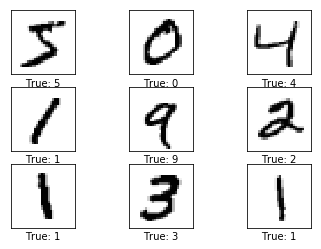

In [9]:
plot_images(X_train, y_train_vec)

### Model build
As stated in its documet, `Keras` "was developed with a focus on enabling fast experimentation ... allows for easy and fast prototyping (through user friendliness, modularity, and extensibility". Building a CNN model is fewer than 20 lines of code.

In [10]:
learning_rate = 1e-3
model = Sequential()
# input layer
model.add(InputLayer(input_shape=(img_rows, img_cols, 1, )))
model.add(Conv2D(32, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
model.add(Conv2D(64, kernel_size=3,
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

Here we define a two-layer CNN model. The first layer is `InputLayer` to receive the raw images. The two convolutional layers have 32 and 64 kernels for each layer respectively. The kernel size is 3x3 for two layers. The default paading rule is 'SAME'. The other option here is "VALID". When using 'SAME', the output height and width are computed as:
```
out_height = ceil(float(in_height) / float(strides[1]))
out_width  = ceil(float(in_width) / float(strides[2]))
```
while for the 'VALID' scheme, the output height and width are computed as:
```
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
```

Especially, **when the stride is 1, the "SAME" option returns the same output height and width as the input height and width**, which makes it easy to compute the filter size.

The convolutional layer is then connected to Maxpooling layer and then flattened to connect a fully-connected layer. The last `Dense` layer outputs the probability of the ten classes.

We specify the loss function to be `categorical_crossentropy`. Mathematically, it equals negative log-likelihood. We choose `Adam` as our optimization method. You can also try other algorithms in `keras.optimizers`.

Though we haven't train our network, we can check its structure first:

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv_1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
layer_conv_2 (Conv2D)        (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                802880    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total para

We now train the model and output its performance on the test set.

In [12]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 95s 2ms/step - loss: 0.1919 - acc: 0.9411 - val_loss: 0.0612 - val_acc: 0.9830
Test loss: 0.06408695189002901
Test accuracy: 0.9799


You can save your model for future use and reload it by
```
model = load_model(model_path)
```

In [13]:
# define the save path for the trained_model
save_path = './trained_model'
save_file = 'cnn_mnist.keras'
# check if the save_path exists
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [14]:
# save the model
model_path = os.path.join(save_path, save_file)
model.save(model_path)
print('Model saved')
# for model reuse in the future, use the following commands
#from keras.models import load_model
#model = load_model(model_path)

# for further investigation, return the label of the test set
y_pred = model.predict_classes(x=X_test)


Model saved


### Model evaluation

We inspect some prediction result of the test set.

Select the first 9 images


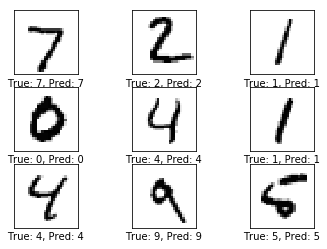

In [15]:
plot_images(X_test, y_test_vec, y_pred)

It is common practive to inspect some misspecified samples, which may help us determine why it doesn't work and provide us some intuition on how to improve the classifier. For example, the following digit 2 is classified as 7. But viually, it does look like 7. It indicates our model is still reasonable.

Select the first 9 images


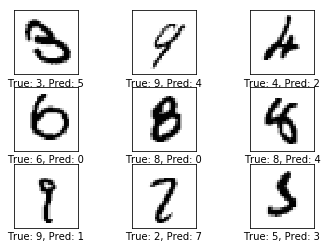

In [16]:
plot_example_errors(X_test, y_test_vec, y_pred)

## Tuning hyperparameters with `skopt`

It may takes centuries to fine-tune all the hyperparameters in CNN through grid search. Fortunately, we can use `skopt` to help us tune efficiently.

We are using `gp_minimize` here which corresponds to Gaussian process optimization. The main idea is to view all the hyperparameters as $x$ and the accuracy on validation set as the target function $f(x)$. Since we only know the function value given $x$ and no other information about its gradient etc., the tuing problem can be considered as "black-box optimization". For traditional grid search, each attemmpt of $x$ is independent. However, Gaussian process optimization offers an efficient sampling method based on the previous search result to help you locate the optimal $x$ efficiently.

In [27]:
from keras.callbacks import TensorBoard
from skopt import gp_minimize, dump, load
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args

We use this method to find the **best learning rate, filter size of the convolutional layer and the number of dense layer**. First we define a function to onstruct CNN quickly given different combination of parameters. Note how we build it with varying number of the fully connected layer.

In [18]:
def create_model(learning_rate, kernel_size, num_dense_layers):
    # Start construction of a Keras Sequential model.
    model = Sequential()
    model.add(InputLayer(input_shape=(img_rows, img_cols, 1, )))
    model.add(Conv2D(32, kernel_size=int(kernel_size),
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_1'))
    model.add(Conv2D(64, kernel_size=int(kernel_size),
                 activation='relu',
                 padding='same',
                 name = 'layer_conv_2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Flatten())
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(64,
                        activation='relu',
                        name=name))
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate),
              metrics=['accuracy'])    
    return model

We wish to save the accuracy of each combination of parameters in different folders. So we use the following function to generate the folder name.

In [19]:
def log_dir_name(learning_rate,
                 kernel_size,
                 num_dense_layers):
    # The dir-name for the TensorBoard log-dir.
    s = os.path.join(log_path, "lr_{0:.0e}_kernel_{1}_dense_{2}/")
    
    log_dir = s.format(learning_rate,
                       kernel_size,
                       num_dense_layers)
    return log_dir

Next is to determine the **search range** of the hyperparameters. Here the learning rate is continuous and ranges from $10^{-4}$ to $10^{-2}$. The kernel size is integer and ranges from 3 to 5. And the number of the fully connected layer ranges from 1 to 3.

In [23]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                             name='learning_rate')
dim_kernel_size = Integer(low=3, high=5, name='kernel_size')
dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers')

dimensions = [dim_learning_rate, dim_kernel_size, dim_num_dense_layers]

For each attempt, we wish to compare the result with the previous models and save the best one.

In [34]:
log_path = './mnist_skopt_log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
result_path = './mnist_skopt_result/'
if not os.path.exists(result_path):
    os.makedirs(result_path)
path_best_model = os.path.join(result_path+'best_model.keras')
best_accuracy = 0.0

`skopt` requires the target function written in the following format. The search space of parameters is passed using the decorator `use_named_args`. It doesn't matter if you don't understand how decorator works. You can just mimick the syntax to define your own target function.

In [25]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, kernel_size, num_dense_layers):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('kernel_size:', kernel_size)
    print('num_dense_layers:', num_dense_layers)
    print()
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate, kernel_size,  num_dense_layers)
     
    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, kernel_size,  num_dense_layers)
     
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        batch_size=32,
        write_graph=True,
        write_grads=False,
        write_images=False)
    
    # Use Keras to train the model.
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[callback_log])
    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

Before we run the optimzization process, we need to specify a starting point. `n_calls` in function `gp_minimize` determines how many $x$ should be sampled. This number should be at least 11.

In [36]:
# initial hyperparameters for search
default_parameters = [1e-4, 3, 1]

# search by Gaussian Process Optimization
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11, # min n_calls=11
                            x0=default_parameters)

learning rate: 1.0e-04
kernel_size: 3
num_dense_layers: 1

Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 90s 2ms/step - loss: 0.5435 - acc: 0.8683 - val_loss: 0.1785 - val_acc: 0.9514

Accuracy: 95.14%

learning rate: 9.8e-03
kernel_size: 5
num_dense_layers: 2

Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 161s 3ms/step - loss: 0.1819 - acc: 0.9450 - val_loss: 0.0774 - val_acc: 0.9786

Accuracy: 97.86%

learning rate: 4.5e-03
kernel_size: 3
num_dense_layers: 2

Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 89s 2ms/step - loss: 0.1491 - acc: 0.9535 - val_loss: 0.0638 - val_acc: 0.9836

Accuracy: 98.36%

learning rate: 2.2e-04
kernel_size: 5
num_dense_layers: 2

Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 164s 3ms/step - loss: 0.3313 - acc: 0.9028 - 

We can save the optimization procedure for future use (e.g. if you want to try more settings and don't want to repeat with the existing parameters you already tried).

In [53]:
# save the search result for future use
dump(search_result,result_path+'search_result.gz', compress=9)
# if you need to reload the optimization history, use the following command
#res_load = load(result_path+'search_result.gz')
f = open(result_path+'best_hyperparameter.txt', 'w')
f.write("learning rate: {0:.1e}, kernel_size:{1}, number of fully connecte layer:{2}".format(search_result.x[0],search_result.x[1],search_result.x[2]))
f.close()

Let's check the result of the searched best model.

In [48]:
model_best = load_model(path_best_model)
score = model_best.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06018458512630313
Test accuracy: 0.9816


The optimal $x$:

In [54]:
search_result.x

[0.0044690090737163225, 3, 2]

We can further investigate other combinations of hyparameters and their corresponding accuracies.

In [57]:
sorted(zip(-search_result.func_vals, search_result.x_iters), reverse=True)

[(0.9836, [0.0044690090737163225, 3, 2]),
 (0.9832, [0.001110768985459163, 3, 1]),
 (0.9814, [0.004677764999980069, 5, 2]),
 (0.9812, [0.0002725833244959208, 4, 1]),
 (0.9786, [0.009763029927194905, 5, 2]),
 (0.977, [0.00022057465915229911, 5, 2]),
 (0.9744, [0.0001768597211718096, 5, 1]),
 (0.961, [0.00018141076342949536, 3, 2]),
 (0.9576, [0.00016258574972475776, 3, 2]),
 (0.9516, [0.00010967343799397746, 3, 2]),
 (0.9514, [0.0001, 3, 1])]

The convergence plot of the optimization procedure:

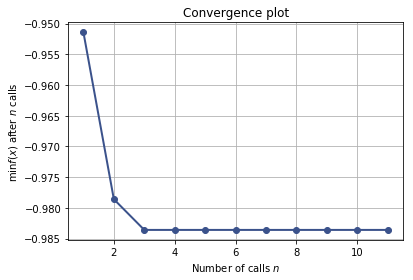

In [58]:
plot_convergence(search_result)